# WGCNA Analysis of Genes

**Created**: 14 October 2021

## Environment

In [1]:
if (!requireNamespace("patchwork")) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

if (!requireNamespace("BiocManager")) {
    install.packages("BiocManager")
}

if (!requireNamespace("WGCNA")) {
    BiocManager::install("WGCNA")
}

if (!requireNamespace("sva")) {
    BiocManager::install("sva")
}

if (!requireNamespace("spqn")) {
    BiocManager::install("spqn")
}

Loading required namespace: patchwork

Loading required namespace: BiocManager

Loading required namespace: WGCNA



Loading required namespace: sva

Loading required namespace: spqn



In [2]:
library(WGCNA)
library(sva)
library(spqn)
library(tidyverse)
library(RColorBrewer)
library(patchwork)

options(stringsAsFactors = FALSE)

setwd("~/eQTL_pQTL_Characterization/")

source("04_Expression/scripts/utils/ggplot_theme.R")

Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust



Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor


Loading required package: mgcv

Loading required package: nlme

This is mgcv 1.8-38. For overview type 'help("mgcv-package")'.

Loading required package: genefilter

Loading required package: BiocParallel

Loading required package: ggplot2

Loading required package: ggridges

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following objects are masked from ‘package:genefilter’:

    rowSds, rowVars



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCu

## Load Data

In [3]:
raw.gene.exp <- read.table("/lustre/scratch119/humgen/projects/gains_team282/eqtl/data/logcpm_864_20412_hla.txt")
gene.info <- read.table("/nfs/team282/data/gains_team282/Gene_info_864_20416.txt")
sample.info <- read.table("/nfs/team282/data/gains_team282/Sample_info_864.txt")
sample.key <- read.table("/nfs/team282/data/gains_team282/Sample_key.txt", header=T)

In [4]:
head(raw.gene.exp)

,UK02270173_3,UK15130120_3,UK58000006_3,UK47010004_3,UK42020088_5,UK47490007_3,UK02770164_3,UK02770164_5,UK02630151_3,UK42150107_1,⋯,UK59070043_3,UK59070043_5,UK02510223_3,UK02XX0336_5,UK29090086_3,UK02XX0335_1,UK02XX0334_3,UK01210130_3,UK01210130_5,UK01380125_1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000230521,0.6644339,0.58271604,0.4046756,0.20905157,0.2211571,0.4288519,0.5133516,0.57768877,0.6990766,0.3812037,⋯,0.3823184,0.5423684,0.86762630,0.73833461,0.6461583,0.1227063,0.9621386,0.65838459,1.03561474,0.4457301
ENSG00000225864,0.9817872,0.43879936,0.6022344,0.92340489,0.2211571,1.1450686,0.1921362,0.57768877,0.1974851,1.2290495,⋯,0.6842527,0.8539227,0.91886777,0.12581620,0.5511865,0.4384007,0.5465139,0.40803066,0.46899151,0.3544115
ENSG00000227766,1.2117156,0.30682669,0.6625010,0.79963286,0.6445686,0.3130290,0.1183231,0.16750450,0.1505900,1.0533199,⋯,0.4901384,0.4340781,0.37504164,0.04316943,0.6151905,0.3406488,0.3147798,0.43511377,0.17382742,0.1157514
ENSG00000237669,0.6420763,0.69256830,0.9792012,0.69929584,0.3765156,1.0756817,0.8912050,0.60129641,0.8534668,1.0533199,⋯,1.0790156,0.6102946,1.03953331,0.97965846,0.7061683,0.7489857,0.7919934,0.85168813,0.69120049,1.0798771
ENSG00000271581,2.4744895,1.33153140,1.8310464,2.47531701,1.8812042,2.0531366,0.5972544,1.00686213,1.2811361,2.4244938,⋯,2.4728831,1.5338898,1.59080138,0.62923925,1.2804253,1.4727511,1.2187650,1.46471386,1.44139443,1.1896250
ENSG00000285647,0.0000000,0.03379072,0.0000000,0.05517067,0.6748270,0.0000000,0.0000000,0.03509293,0.6990766,1.6556266,⋯,3.4117627,2.4012963,0.04682116,0.00000000,0.0000000,0.4695662,0.3762952,0.07078527,0.07206309,0.4159282


In [5]:
dim(raw.gene.exp)

[1] 20412   864

Some patient identifiers may have a GA- prefix that has been dropped in future releases of the data. If this identifier exists, I drop the prefix.

In [6]:
colnames(raw.gene.exp) <- gsub("^GA", "", colnames(raw.gene.exp))

In [7]:
head(gene.info)

,seqnames,start,end,width,strand,source,type,score,phase,gene_id,⋯,transcript_source,transcript_biotype,tag,transcript_support_level,exon_number,exon_id,exon_version,protein_id,protein_version,ccds_id
,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
1248375,X,100627108,100639991,12884,-,ensembl_havana,gene,NA,NA,ENSG00000000003,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2612838,20,50934867,50958555,23689,-,ensembl_havana,gene,NA,NA,ENSG00000000419,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
198068,1,169849631,169894267,44637,-,ensembl_havana,gene,NA,NA,ENSG00000000457,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
197489,1,169662007,169854080,192074,+,ensembl_havana,gene,NA,NA,ENSG00000000460,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
46865,1,27612064,27635185,23122,-,ensembl_havana,gene,NA,NA,ENSG00000000938,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
213754,1,196652043,196747504,95462,+,ensembl_havana,gene,NA,NA,ENSG00000000971,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [8]:
dim(gene.info)

[1] 20416    27

In [9]:
head(sample.info)

,manual_qc,id_study_lims,name,description,sanger_sample_id,supplier_name,last_updated,id_library_lims,id_pool_lims,id_iseq_flowcell_tmp,⋯,TIN.mean.,TIN.median.,TIN.stdev.,Concentration,num_samples_per_lane,SRSUnsup,globin_rate_fromcounts,PCOutlier,OtherOutlier,GAinSID
,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<lgl>,<lgl>,<chr>
gains8032857,1,5890,HG_The Genomic Advances in Sepsis (GAinS) RNA-seq,Total leukocyte RNA,gains8032857,UK02270173_3,2019-09-30 21:01:38,DN548016D,NT1557159B,6930558,⋯,69.51307,76.82800,23.72743,116.731,77,2,0.6790401,FALSE,FALSE,UK02270173
gains8032858,1,5890,HG_The Genomic Advances in Sepsis (GAinS) RNA-seq,Total leukocyte RNA,gains8032858,UK15130120_3,2019-09-30 21:01:38,DN548016D,NT1557159B,6930559,⋯,65.03706,71.49895,24.13243,76.185,77,2,0.6826886,FALSE,FALSE,UK15130120
gains8032859,1,5890,HG_The Genomic Advances in Sepsis (GAinS) RNA-seq,Total leukocyte RNA,gains8032859,UK58000006_3,2019-09-30 21:01:38,DN548016D,NT1557159B,6930560,⋯,70.85535,78.07773,23.24183,59.767,77,2,1.4290063,FALSE,FALSE,UK58000006
gains8032860,1,5890,HG_The Genomic Advances in Sepsis (GAinS) RNA-seq,Total leukocyte RNA,gains8032860,UK47010004_3,2019-09-30 21:01:38,DN548016D,NT1557159B,6930561,⋯,68.16224,75.05450,23.56361,105.000,77,1,0.9177558,FALSE,FALSE,UK47010004
gains8032861,1,5890,HG_The Genomic Advances in Sepsis (GAinS) RNA-seq,Total leukocyte RNA,gains8032861,UK42020088_5,2019-09-30 21:01:38,DN548016D,NT1557159B,6930562,⋯,64.67378,72.53810,26.03766,87.843,77,1,0.4031685,FALSE,FALSE,UK42020088
gains8032862,1,5890,HG_The Genomic Advances in Sepsis (GAinS) RNA-seq,Total leukocyte RNA,gains8032862,UK47490007_3,2019-09-30 21:01:38,DN548016D,NT1557159B,6930563,⋯,62.79935,68.60305,24.27960,67.484,77,2,1.1993500,FALSE,FALSE,UK47490007


In [10]:
dim(sample.info)

[1] 864  46

Some patient identifiers may have a GA- prefix that has been dropped in future releases of the data. If this identifier exists, I drop the prefix.

In [11]:
sample.info$supplier_name <- gsub("^GA", "", sample.info$supplier_name)

In [12]:
head(sample.key)

,SangerSampleID,GAinSID
,<chr>,<chr>
1,gains8032857,UK02270173_3
2,gains8032858,UK15130120_3
3,gains8032859,UK58000006_3
4,gains8032860,UK47010004_3
5,gains8032861,UK42020088_5
6,gains8032862,UK47490007_3


In [13]:
dim(sample.key)

[1] 864   2

Some patient identifiers may have a GA- prefix that has been dropped in future releases of the data. If this identifier exists, I drop the prefix.

In [14]:
sample.key$GAinSID <- gsub("^GA", "", sample.key$GAinSID)

## Gene Expression Correction

Gene expression data may contain counfounding technical variation that can lead to spurious associations between genes. This is based on an analysis conducted by Parsana *et al.* [here](https://doi.org/10.1186/s13059-019-1700-9). This can be corrected using their method implemented in the `sva` package.

In [15]:
gene.exp <- sva_network(raw.gene.exp, 20)

In [16]:
gene.exp <- t(gene.exp)

## Between-Individual Gene Expression

Gene expression has been measured both within and between individuals. In this co-expression analysis, we are specifically interested in between-individual variation. I will use weighted correlation by using the mean gene expression value for a sample from each individual. This idea is discussed [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2549010/?page=1).

In [17]:
individuals <- unique(gsub("_.$", "", rownames(gene.exp)))

In [18]:
for (individual in individuals) {
    mask = grepl(individual, rownames(gene.exp))
    gene.exp[mask,] = do.call(rbind, rep(list(apply(gene.exp[mask,,drop=F], 2, mean)), sum(mask)))
}

## WGCNA Checks

The following function identifies genes with excessive missing values and outlier samples. It is generally more important for microarray data.

In [19]:
gsg <- goodSamplesGenes(gene.exp)
gsg$allOK

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

## Mean-Correlation Bias

There is a mean-correlation bias when building co-expression modules, as discussed by Wang *et al.* [here](https://doi.org/10.1371/journal.pcbi.1009954). This can be corrected using a method they developed.

In [20]:
cor.mtx <- bicor(gene.exp, use="pairwise.complete.obs", pearsonFallback="individual")

avg.exp <- apply(raw.gene.exp, 1, mean)

Warning message:
“Continuous limits supplied to discrete scale.
Did you mean `limits = factor(...)` or `scale_*_continuous()`?”
Picking joint bandwidth of 0.00766



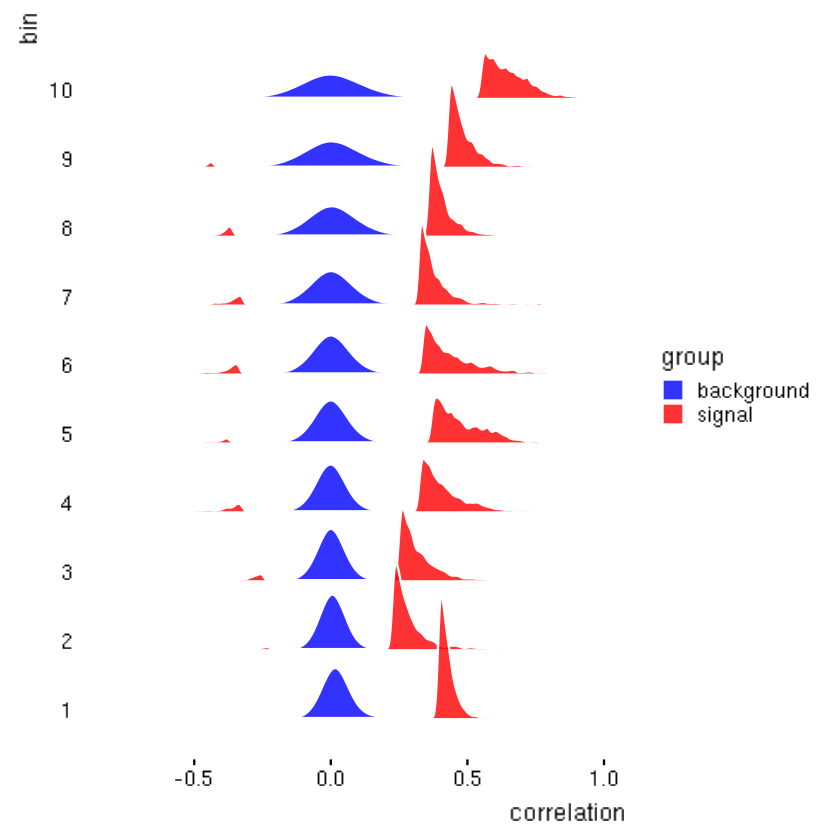

In [21]:
plot_signal_condition_exp(cor.mtx, avg.exp, signal=0.001)

In [22]:
cor.mtx.norm <- normalize_correlation(cor.mtx, ave_exp=avg.exp, ngrp=21, size_grp=1000, ref_grp=18)

In [23]:
rownames(cor.mtx.norm) <- rownames(cor.mtx)
colnames(cor.mtx.norm) <- colnames(cor.mtx)

In [24]:
saveRDS(cor.mtx.norm, file="~/gains_team282/nikhil/expression/gene_expression/correlation.matrix.RDS")

Warning message:
“Continuous limits supplied to discrete scale.
Did you mean `limits = factor(...)` or `scale_*_continuous()`?”
Picking joint bandwidth of 0.00701



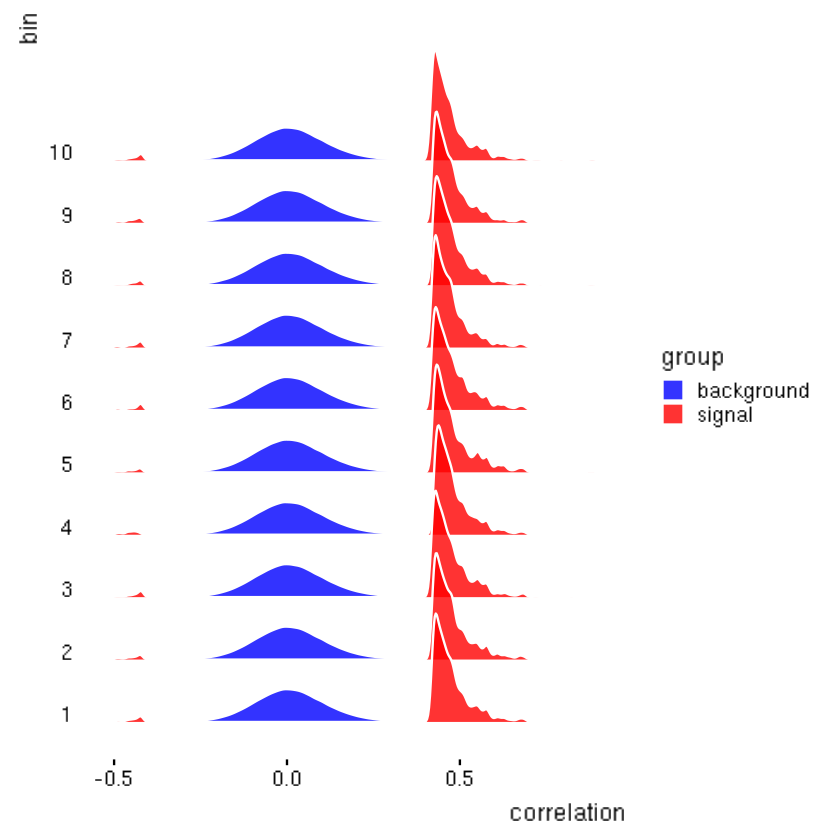

In [25]:
plot_signal_condition_exp(cor.mtx.norm, avg.exp, signal=0.001)

## Soft Threshold

The adjacency matrix generated using the correlation function does not fit a scale-free topology. A scaling function is used to generate the appropriate gene degree distribution. A parameter of this scaling function, $\beta$, is estimated by trying multiple values and checking how well the resulting network fits the assumptions of a scale-free network. Here, I try all integer values in $[1,20]$.

In [26]:
powers = seq(1, 20, by=1)

# Warning being suppressed - Pearson fallback used when MAD is zero in bicor
soft.thresholds = suppressWarnings(
    pickSoftThreshold(cor.mtx.norm, dataIsExpr=F, powerVector=powers, networkType="unsigned", verbose=0)
)

soft.threshold = soft.thresholds$powerEstimate

Called from: pickSoftThreshold(cor.mtx.norm, dataIsExpr = F, powerVector = powers, 
    networkType = "unsigned", verbose = 0)
debug: SFT1 = scaleFreeFitIndex(k = khelp, nBreaks = nBreaks, removeFirst = removeFirst)
debug: datout[i, 2] = SFT1$Rsquared.SFT
debug: datout[i, 3] = SFT1$slope.SFT
debug: datout[i, 4] = SFT1$truncatedExponentialAdjRsquared
debug: datout[i, 5] = mean(khelp, na.rm = TRUE)
debug: datout[i, 6] = median(khelp, na.rm = TRUE)
debug: datout[i, 7] = max(khelp, na.rm = TRUE)
debug: if (moreNetworkConcepts) {
    Density = sum(khelp)/(nGenes * (nGenes - 1))
    datout[i, 8] = Density
    Centralization = nGenes * (max(khelp) - mean(khelp))/((nGenes - 
        1) * (nGenes - 2))
    datout[i, 9] = Centralization
    Heterogeneity = sqrt(nGenes * sum(khelp^2)/sum(khelp)^2 - 
        1)
    datout[i, 10] = Heterogeneity
}
debug: khelp = datk[, i]
debug: if (any(khelp < 0)) browser()
debug: SFT1 = scaleFreeFitIndex(k = khelp, nBreaks = nBreaks, removeFirst = removeFirst)
de

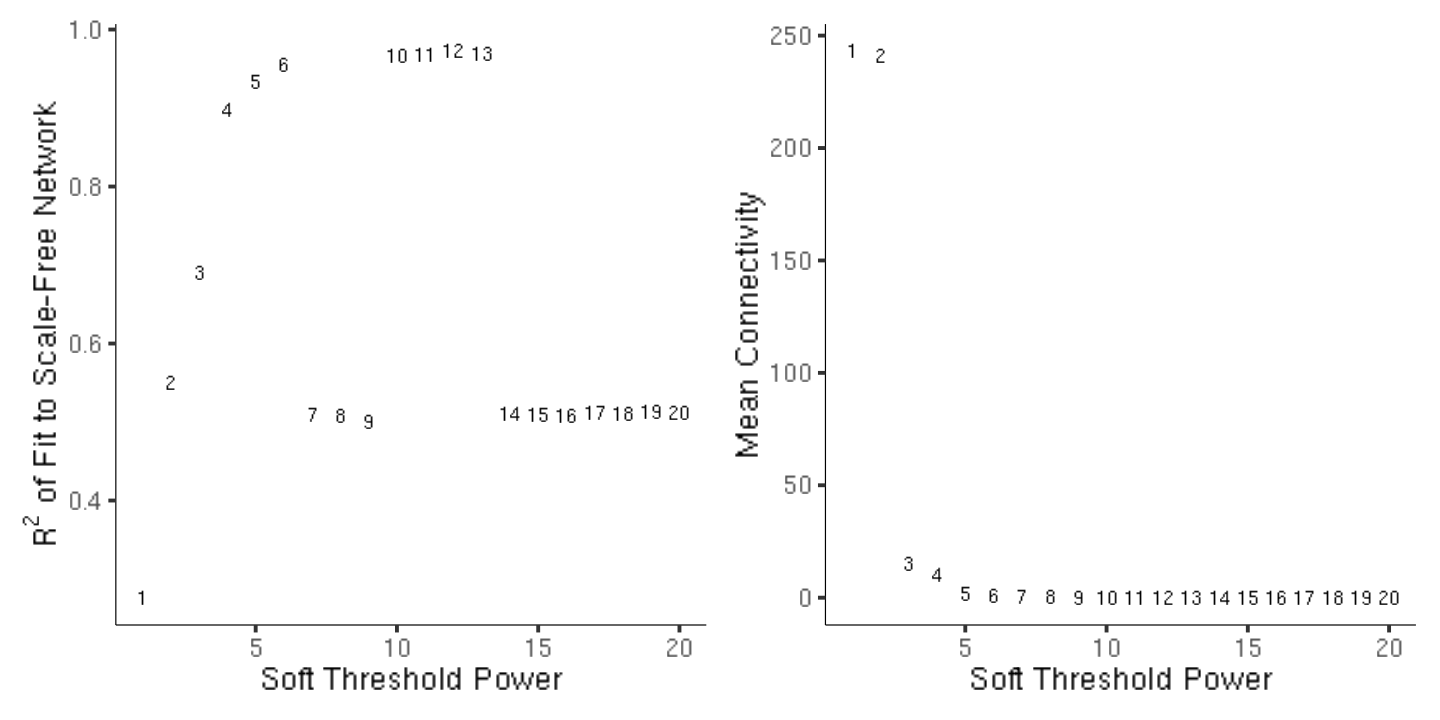

In [27]:
options(repr.plot.width=12, repr.plot.height=6)

p1 <- soft.thresholds$fitIndices %>%
    ggplot() +
    geom_text(aes(x=Power, y=SFT.R.sq, label=Power)) +
    xlab("Soft Threshold Power") + ylab(bquote(R^2*" of Fit to Scale-Free Network")) +
    ggplot_theme

p2 <- soft.thresholds$fitIndices %>%
    ggplot() +
    geom_text(aes(x=Power, y=mean.k., label=Power)) +
    xlab("Soft Threshold Power") + ylab("Mean Connectivity") +
    ggplot_theme

p1 + p2

In [28]:
print(soft.threshold)

[1] 4


## Adjacency and TOM Matrices

The adjacency matrix defines the similarity between all genes in the sample data. I am using the [biweight midcorrelation](https://en.wikipedia.org/wiki/Biweight_midcorrelation) (`bicor`) function to estimate similarity. It is a median-based approach that is less sensitive to outliers.

I use $\beta=16$ for the scaling function, which was determined in the previous step. Then, the topological overlap metric (TOM) matrix is generated from the adjacency matrix. For details, check the original WGCNA paper.

In [29]:
adjacency.matrix = adjacency.fromSimilarity(cor.mtx.norm, type="unsigned", power=soft.threshold)

In [30]:
saveRDS(adjacency.matrix, file="~/gains_team282/nikhil/expression/gene_expression/adjacency.matrix.RDS")

In [31]:
TOM.matrix = TOMsimilarity(adjacency.matrix)

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


In [32]:
rownames(TOM.matrix) <- rownames(adjacency.matrix)
colnames(TOM.matrix) <- colnames(adjacency.matrix)

In [33]:
saveRDS(TOM.matrix, file="~/gains_team282/nikhil/expression/gene_expression/TOM.matrix.RDS")

In [34]:
TOM.dist = 1 - TOM.matrix

## Clustering TOM Matrix

The gene co-expression modules are generated by clustering the TOM matrix.

In [35]:
dendrogram = hclust(as.dist(TOM.dist), method="average")

svg(filename="04_Expression/results/gene_expression_dendrogram.svg", width=8, height=5)
plot(dendrogram, labels=FALSE, main="Gene Expression TOM Dendrogram")
dev.off()

dynamic.mods = cutreeDynamic(
  dendro=dendrogram, distM=TOM.dist, pamRespectsDendro=FALSE,
  minClusterSize = 10
)
rm(TOM.dist)

png 
  2

 ..cutHeight not given, setting it to 0.999  ===>  99% of the (truncated) height range in dendro.
 ..done.


In [36]:
table(dynamic.mods)

dynamic.mods
   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
   6 1785 1557 1197  962  733  690  632  605  599  591  545  528  505  432  404 
  16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31 
 391  374  369  365  330  315  315  257  256  240  228  225  225  213  211  204 
  32   33   34   35   36   37   38   39   40   41   42   43   44   45   46   47 
 198  193  171  168  162  147  125  122  120  117  112  111  106  104  103   97 
  48   49   50   51   52   53   54   55   56   57   58   59   60   61   62   63 
  96   94   94   93   74   74   68   67   67   62   61   51   48   47   45   41 
  64   65   66   67   68   69   70   71   72   73   74   75   76   77   78   79 
  40   40   37   37   36   34   34   32   31   31   28   25   24   23   23   22 
  80   81   82   83   84   85   86   87   88   89   90   91   92   93   94   95 
  22   22   21   20   19   17   15   15   14   14   14   14   14   14   13   13 
  96   97   98 

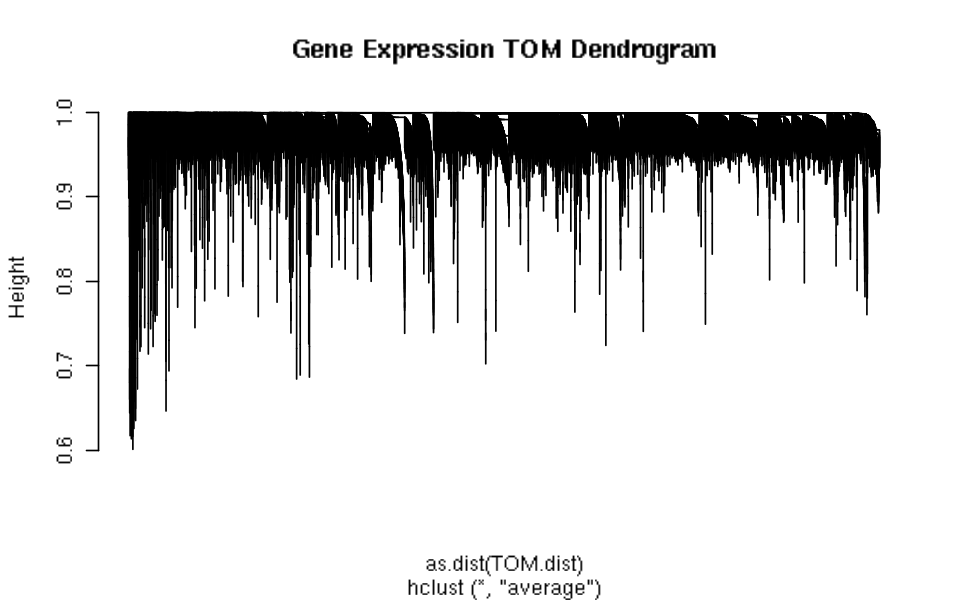

In [37]:
options(repr.plot.width=8, repr.plot.height=5)

plot(dendrogram, labels=FALSE, main="Gene Expression TOM Dendrogram")

Here, I merge similar modules based on their module eigengenes. I am merging all modules with a distance of less than 0.1 (a correlation between module eigengenes of greater than 0.9)

In [38]:
me.data = moduleEigengenes(gene.exp, colors=dynamic.mods)
me = me.data$eigengenes
me.dist = 1 - cor(me, use="p", method="spearman")
me.tree = hclust(as.dist(me.dist), method="average")

In [39]:
svg(filename="04_Expression/results/initial_module_tree.svg", width=10, height=6)
plot(me.tree, main="Clustering of Module Eigengenes")

me.dist.threshold = 0.1
abline(h=me.dist.threshold, col="firebrick1")
dev.off()

png 
  2

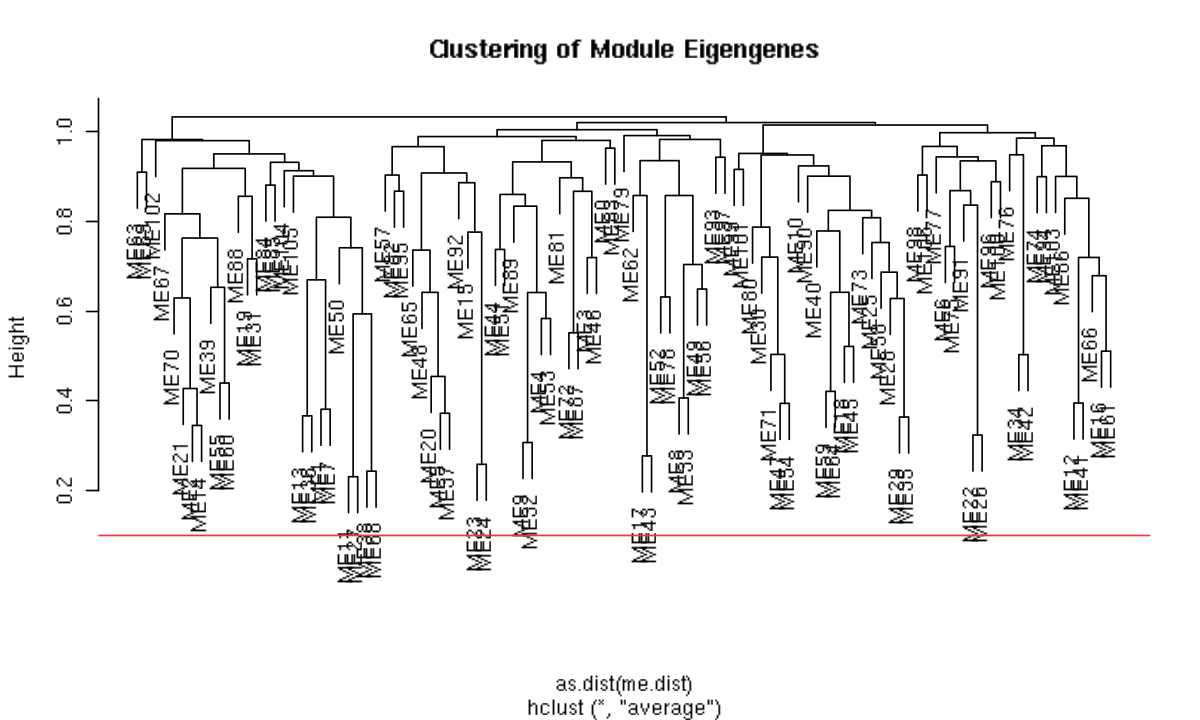

In [40]:
options(repr.plot.width=10, repr.plot.height=6)
plot(me.tree, main="Clustering of Module Eigengenes")
abline(h=me.dist.threshold, col="firebrick1")

In [41]:
merge = mergeCloseModules(
    gene.exp, 
    colors=dynamic.mods, 
    cutHeight=me.dist.threshold,
    corOptions=list(use="p", method="spearman")
)
merge.mods = merge$colors

 mergeCloseModules: Merging modules whose distance is less than 0.1
   Calculating new MEs...


The merged modules are not labeled by frequency. I refactor the module names to name them in decreasing order. The 0-th module represents unassigned genes and remains 0 regardless of the number of genes in the module.

In [42]:
merge.mods.no.zero = merge.mods[merge.mods != 0]

freq.mod.labels = 0:length(table(merge.mods.no.zero))
names(freq.mod.labels) = c("0", names(table(merge.mods.no.zero))[order(table(merge.mods.no.zero), decreasing=T)])

merge.mods = as.numeric(as.character(plyr::revalue(factor(merge.mods), replace=freq.mod.labels)))

In [43]:
table(merge.mods)

merge.mods
   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
   6 1785 1557 1197  962  733  690  632  605  599  591  545  528  505  432  404 
  16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31 
 391  374  369  365  330  315  315  257  256  240  228  225  225  213  211  204 
  32   33   34   35   36   37   38   39   40   41   42   43   44   45   46   47 
 198  193  171  168  162  147  125  122  120  117  112  111  106  104  103   97 
  48   49   50   51   52   53   54   55   56   57   58   59   60   61   62   63 
  96   94   94   93   74   74   68   67   67   62   61   51   48   47   45   41 
  64   65   66   67   68   69   70   71   72   73   74   75   76   77   78   79 
  40   40   37   37   36   34   34   32   31   31   28   25   24   23   23   22 
  80   81   82   83   84   85   86   87   88   89   90   91   92   93   94   95 
  22   22   21   20   19   17   15   15   14   14   14   14   14   14   13   13 
  96   97   98   

## Intra- and Inter-Module Connectivity

Connectivity is a measure assigned to each gene that describes how well the gene fits into a certain group of genes. Intra-module connectivity is a measure of how well the gene belongs to the module, Conversely, inter-module connectivity is a measure of how well the gene belongs to all other genes outside the module. Genes that are more "central" in the module will tend to have a high intra-module connectivity and a low inter-module connectivity.

In [44]:
connectivity <- intramodularConnectivity(TOM.matrix, colors=merge.mods)
rownames(connectivity) <- colnames(gene.exp)

## Co-Expression Module Size Distribution

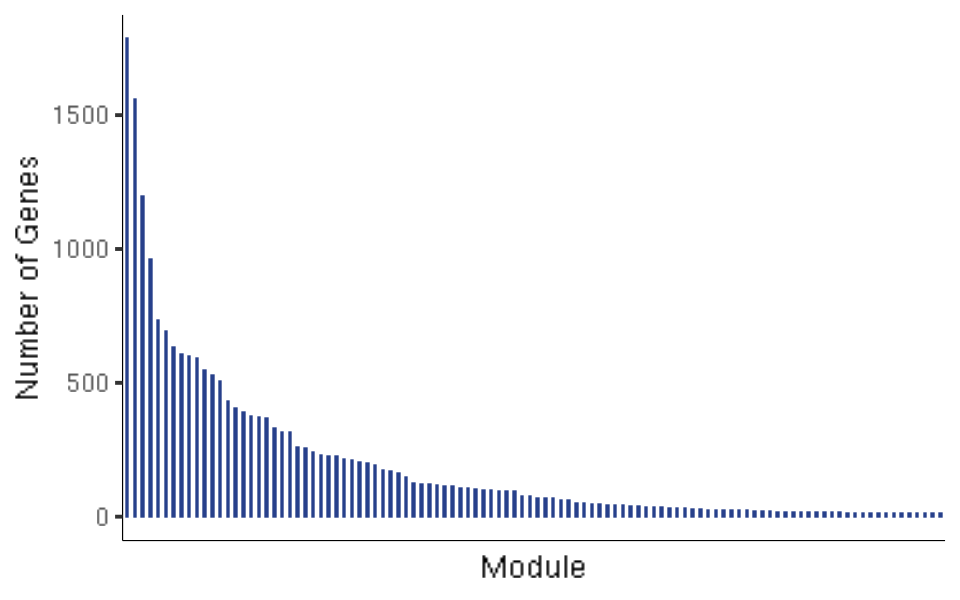

In [47]:
plot.data <- as.data.frame(table(merge.mods)) %>%
  dplyr::select(Module=1, Frequency=Freq) %>%
  dplyr::filter(Module != 0)

options(repr.plot.width=8, repr.plot.height=5)

ggplot(plot.data) +
  geom_col(aes(x=Module, y=Frequency), color="royalblue4", width=0.2) +
  xlab("Module") + ylab("Number of Genes") +
  ggplot_theme +
  theme(axis.text.x=element_blank(), axis.ticks.x=element_blank())
ggsave(filename="04_Expression/results/gene_coexpression_module_sizes.pdf", width=8, height=5)

## Save Gene Co-Expression Modules

I save a the list of genes and their assigned modules, the eigengenes, the variance explained by each eigengene, and the connectivity information for each gene.

The modules are labelled `Module_1,Module_2,...`. `Module_0` contains genes that were not assigned to any co-expression module by WGCNA and are therefore labelled as `Unassigned`.

The eigengene of a given co-expression module is the first principal component of the gene expression for the genes within the module.

The variance explained by each eigengene tells us how well the eigengene captures the overall variation found within the module expression data.

In [46]:
### Module Assignment

gene.list <- colnames(gene.exp)

mod.assignment <- merge.mods
mod.labels <- paste0("Module_", mod.assignment)
mod.labels[mod.labels == "Module_0"] <- "Unassigned"

modules <- data.frame(
  Gene=gene.list,
  Module=mod.labels
) %>%
  dplyr::arrange(Module, Gene)

write.csv(modules, "~/gains_team282/nikhil/expression/gene_expression/modules.csv", row.names=F)

### Eigengenes

eigengenes.result <- moduleEigengenes(t(raw.gene.exp)[,mod.labels != "Unassigned"], colors=mod.labels[mod.labels != "Unassigned"])
eigengene.order <- order(as.numeric(sapply(strsplit(colnames(eigengenes.result$eigengenes), "_"), function(x) x[2])))

eigengenes <- eigengenes.result$eigengenes
colnames(eigengenes) <- sapply(strsplit(colnames(eigengenes), "_"), function(x) paste0("ME_", x[2]))
eigengenes <- eigengenes[,eigengene.order]

rownames(eigengenes) <- rownames(gene.exp)

write.csv(eigengenes, "~/gains_team282/nikhil/expression/gene_expression/eigengenes.csv")

variance.explained <- data.frame(
  Module=colnames(eigengenes),
  Var.Explained=t(eigengenes.result$varExplained[eigengene.order])[,1]
)

write.csv(variance.explained, "~/gains_team282/nikhil/expression/gene_expression/variance.explained.csv", row.names=F)

### Connectivity

connectivity <- connectivity[modules$Gene,]
connectivity <- cbind(connectivity, modules$Module)
colnames(connectivity)[ncol(connectivity)] <- "Module"

write.csv(connectivity, "~/gains_team282/nikhil/expression/gene_expression/connectivity.csv")

In [52]:
module.set = paste0("Module_", 1:max(mod.assignment))

module.exp = t(raw.gene.exp)[,mod.labels != "Unassigned"]
module.vec = mod.labels[mod.labels != "Unassigned"]

module.eigens = do.call(cbind, lapply(module.set, function(x) {
    module.svd = svd(scale(module.exp[, module.vec == x]))
    module.top.eigens = module.svd$u[,1:5]
    colnames(module.top.eigens) <- paste0(gsub("Module", "ME", x), "_", 1:5)
    return(module.top.eigens)
}))
rownames(module.eigens) <- rownames(gene.exp)

write.csv(module.eigens, "~/gains_team282/nikhil/expression/gene_expression/eigengenes.multiple.csv")

In [51]:
module.set = paste0("Module_", 1:max(mod.assignment))

module.exp = gene.exp[,mod.labels != "Unassigned"]
module.vec = mod.labels[mod.labels != "Unassigned"]

module.eigens.20pcs = do.call(cbind, lapply(module.set, function(x) {
    module.svd = svd(scale(module.exp[, module.vec == x]))
    module.top.eigens = module.svd$u[,1:5]
    colnames(module.top.eigens) <- paste0(gsub("Module", "ME", x), "_", 1:5)
    return(module.top.eigens)
}))
rownames(module.eigens.20pcs) <- rownames(gene.exp)

write.csv(module.eigens.20pcs, "~/gains_team282/nikhil/expression/gene_expression/eigengenes.multiple.20pc_corrected.csv")